In [1]:
import cppyy
import cppyy.gbl as cpp
from cppyy.gbl import std

from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

2023-02-18 16:42:47.020204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 16:42:47.819671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 16:42:47.819691: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-18 16:42:50.236041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-1

In [2]:
cppyy.include('src/value.hpp')
cppyy.include('src/module.hpp')
cppyy.include('src/utils.hpp')

True

In [3]:
(raw_train_X, raw_train_y), (raw_test_X, raw_test_y) = mnist.load_data()
train_X = std.vector[std.vector[float]]()
train_y = std.vector[std.vector[float]]()
test_X = std.vector[std.vector[float]]()
test_y = std.vector[std.vector[float]]()

[train_X.push_back(std.vector[float](list(x.flatten()/255 - 0.5))) for x in raw_train_X];
[train_y.push_back(std.vector[float](list(np.eye(10)[y]))) for y in raw_train_y];
[test_X.push_back(std.vector[float](list(x.flatten()/255 - 0.5))) for x in raw_test_X];
[test_y.push_back(std.vector[float](list(np.eye(10)[y]))) for y in raw_test_y];

7


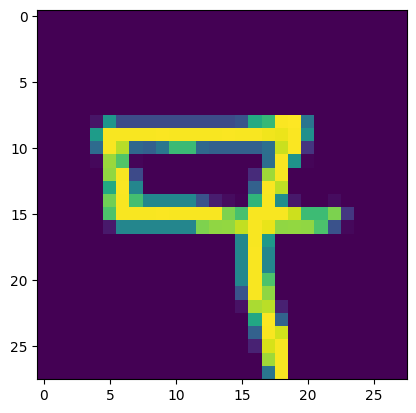

In [5]:
test_ind = np.random.randint(0, len(raw_train_X))
plt.imshow(raw_train_X[test_ind])
print(raw_train_y[test_ind])

In [12]:
mnist_model = cpp.MLP[float]([784, 30, 10])

In [13]:
BATCH = 50
EPOCHS = 3
LOSSES = []
running_loss = 0

for i in range(EPOCHS):
    for j in range(0, len(train_X), BATCH):
        for k in range(min(BATCH, len(train_X)-j)):
            loss = mnist_model.loss(train_X[j+k], train_y[j+k])
            loss.backward()
            running_loss += loss.get_data()
        mnist_model.descend_grad(0.0005)
        mnist_model.zero_grad()
        print(f"Epoch: {i}, Batch: {j}, Loss: {running_loss/k}")
        running_loss = 0.0

Epoch: 0, Batch: 0, Loss: 3.2489562350876477
Epoch: 0, Batch: 50, Loss: 1.6736165771679001
Epoch: 0, Batch: 100, Loss: 0.9539250403034444
Epoch: 0, Batch: 150, Loss: 0.9375192535166837
Epoch: 0, Batch: 200, Loss: 0.9574893895460634
Epoch: 0, Batch: 250, Loss: 0.9379224886699599
Epoch: 0, Batch: 300, Loss: 0.9296782223545775
Epoch: 0, Batch: 350, Loss: 0.9012387261098745
Epoch: 0, Batch: 400, Loss: 0.9188261652479366
Epoch: 0, Batch: 450, Loss: 0.917553152356829
Epoch: 0, Batch: 500, Loss: 0.9118846654891968
Epoch: 0, Batch: 550, Loss: 0.9391651749610901
Epoch: 0, Batch: 600, Loss: 0.9113842029960788
Epoch: 0, Batch: 650, Loss: 0.9232379027775356
Epoch: 0, Batch: 700, Loss: 0.9194877974841059
Epoch: 0, Batch: 750, Loss: 0.8918327531036065
Epoch: 0, Batch: 800, Loss: 0.9128885305657679
Epoch: 0, Batch: 850, Loss: 0.8963452918188912
Epoch: 0, Batch: 900, Loss: 0.9120922575191576
Epoch: 0, Batch: 950, Loss: 0.8883455237563775
Epoch: 0, Batch: 1000, Loss: 0.9031698959214347
Epoch: 0, Batch:

In [14]:
count = 0
for x, y in zip(test_X, test_y):
    if np.argmax([val.get_data() for val in mnist_model(x)]) == np.argmax(y):
        count += 1
print(f"Accuracy: {count/len(test_X)}")

Accuracy: 0.8485


In [15]:
test_dict = dict()

for i, (x, y) in enumerate(zip(test_X, test_y)):
    prediction = np.argmax([val.get_data() for val in mnist_model(x)])
    test_dict[i] = (prediction, np.argmax(y))

fail_dict = {k:v for k,v in test_dict.items() if v[0] != v[1]}

Prediction: 3, Actual: 2


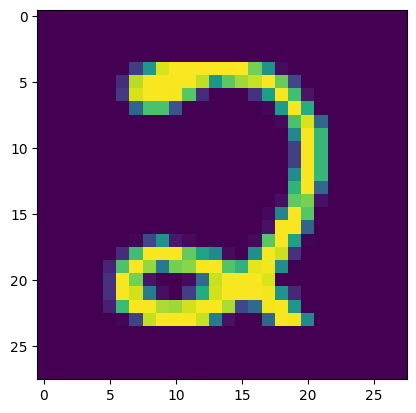

In [27]:
def visualise_error(ind):
    plt.imshow(raw_test_X[ind])
    print(f"Prediction: {fail_dict[ind][0]}, Actual: {fail_dict[ind][1]}")

all_fail = list(fail_dict.keys())

visualise_error(all_fail[10])